In [307]:
!nvidia-smi

Sat Oct 24 02:20:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 16%   42C    P0    51W / 250W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1B:00.0 Off |                  N/A |
| 20%   45C    P0    70W / 250W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [308]:

import os

#using GPU, comment out if on CPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '4'


import tensorflow as tf
print(tf.__version__)
import flowpm

from flowpm import linear_field, lpt_init, nbody, cic_paint
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline
import numpy as np 

1.15.0


In [309]:
import tensorflow as tf
#tf.compat.v1.enable_eager_execution()

import numpy as np
from numpy.testing import assert_allclose
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline
#from nbodykit.cosmology import Cosmology, EHPower, Planck15

#from pmesh.pm import ParticleMesh
import flowpm.tfpm as tfpm
import flowpm.utils as pmutils

from flowpm import linear_field, lpt_init, nbody, cic_paint
import tensorflow as tf
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline



In [310]:
import numpy as np
import numpy


def _initialize_pk(shape,boxsize,kmin,dk):
    """
       Helper function to initialize various (fixed) values for powerspectra... not differentiable!
    """
    I = np.eye(len(shape), dtype='int') * -2 + 1

    W = np.empty(shape, dtype='f4')
    W[...] = 2.0
    W[..., 0] = 1.0
    W[..., -1] = 1.0
    kedges = np.arange(kmin, np.pi * 3 / 2 + dk/2, dk)

    k = [np.fft.fftfreq(N, 1. / (N * 2 * np.pi / L))[:pkshape].reshape(kshape) for N, L, kshape, pkshape in zip(shape.as_list(), boxsize, I, shape.as_list())]
    kmag = sum(ki ** 2 for ki in k) ** 0.5

    xsum = np.zeros(len(kedges) + 1)
    Nsum = np.zeros(len(kedges) + 1)

    dig = np.digitize(kmag.flat, kedges)

    print(dig.size,xsum.size,len((W * kmag).flat))
    xsum.flat += np.bincount(dig, weights=(W * kmag).flat, minlength=xsum.size)
    Nsum.flat += np.bincount(dig, weights=W.flat, minlength=xsum.size)
    dig = tf.convert_to_tensor(dig,dtype=tf.int32)
    Nsum = tf.convert_to_tensor(Nsum,dtype=tf.complex64)
    xsum = tf.convert_to_tensor(np.array(xsum))
    W = tf.convert_to_tensor(np.array(W))
    k = np.array(k)
    kedges = tf.convert_to_tensor(np.array(kedges))
    return dig, Nsum, xsum, W, k, kedges


def pk(field,kmin=5,dk=0.8,shape = False,boxsize= False):   
    """
    Calculate the powerspectra given real space field
    
    Args:
        
        field: real valued field 
        kmin: minimum k-value for binned powerspectra
        dk: differential in each kbin
        shape: shape of field to calculate field (can be strangely shaped?)
        boxsize: length of each boxlength (can be strangly shaped?)
    
    Returns:
        
        kbins: the central value of the bins for plotting
        power: real valued array of power in each bin
        
    """
    
    print(field.shape)
    #initialze values related to powerspectra
    dig, Nsum, xsum, W, k, kedges = _initialize_pk(shape,boxsize,kmin,dk)
    
    
    #convert field to complex for fft
    field_complex = tf.dtypes.cast(field,dtype=tf.complex64)

    #fast fourier transform
    fft_image = tf.signal.fft3d(field_complex)
    
    #absolute value of fast fourier transform
    pk = tf.math.real(fft_image*tf.math.conj(fft_image))
    #calculating powerspectra
    Psum = tf.zeros(tf.size(kedges) + 1, dtype=tf.complex64)
    real = tf.reshape(tf.math.real(pk),[-1,])
    imag = tf.reshape(tf.math.imag(pk),[-1,])
    
    Psum  += tf.dtypes.cast(tf.math.bincount(dig, weights=(tf.reshape(W,[-1])  * imag), minlength=tf.size(xsum)),dtype=tf.complex64)*1j
    Psum  += tf.dtypes.cast(tf.math.bincount(dig, weights=(tf.reshape(W,[-1]) * real), minlength=tf.size(xsum)),dtype=tf.complex64)
    #print(W.flatten()  * imag,Psum)

    power = (Psum / Nsum)[1:-1] * boxsize.prod() 
    
    #normalization for powerspectra
    norm = tf.dtypes.cast(tf.reduce_prod(shape),dtype=tf.float32)**2
    
    #find central values of each bin
    kbins = kedges[:-1]+ (kedges[1:] - kedges[:-1])/2
    
    return kbins,tf.dtypes.cast(power,dtype=tf.float32)/norm

In [311]:

np.random.seed(100)

bs = 128
nc = 128

from flowpm import linear_field, lpt_init, nbody, cic_paint
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline

klin = np.loadtxt('../data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('../data/Planck15_a1p00.txt').T[1]

ipklin = iuspline(klin, plin)


In [312]:
import flowpm

stages = np.linspace(0.1, 0.66, 3, endpoint=True) #z = 0.5

initial_conditions = flowpm.linear_field(nc,          # size of the cube
                                         bs,         # Physical size of the cube
                                         ipklin,      # Initial powerspectrum
                                         batch_size=1)

# Sample particles
state = flowpm.lpt_init(initial_conditions, a0=0.1)   

# Evolve particles down to z=0
final_state = flowpm.nbody(state, stages, nc)         

# Retrieve final density field
final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])
#pk_pow = pk(final_field[0],shape = final_field[0].shape, boxsize= np.array([bs,bs,bs]))


#absolute value of fast fourier transform
pkr = pk(tf.squeeze(initial_conditions,0),shape = final_field.shape[1:], boxsize= np.array([128,128,128]),kmin=0.001,dk=.05)

import time


start_time = time.time()
with tf.Session() as sess:
    istate,fstate,linear_true, final_true,pk_fid = sess.run((state,final_state,initial_conditions,final_field,pkr))
    
print(-start_time+time.time())

(128, 128, 128)
2097152 96 2097152


/home/ben.horowitz/flowpm/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


12.683292388916016


Populating the interactive namespace from numpy and matplotlib


/home/ben.horowitz/flowpm/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


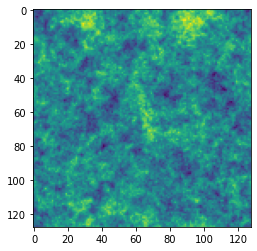

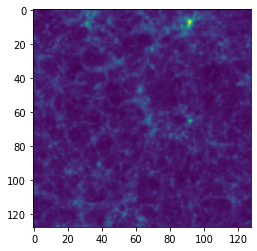

In [313]:
%pylab inline

#Initial and Evolved fields

imshow(np.sum(linear_true[0],axis=1))
show()
imshow(np.sum(final_true[0],axis=1))

In [314]:
from flowpm.kernels import fftk

#setting up prior for model
kvec = fftk((nc, nc, nc), symmetric=False)
kmesh = sum((kk / bs * nc)**2 for kk in kvec)**0.5
pkmesh = ipklin(kmesh)

/home/ben.horowitz/flowpm/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  """


In [315]:
#variable noise... NOT USED!
a = numpy.arange(nc)
numpy.random.shuffle(a)

noise_prop = np.ones((nc,nc,nc))*1.0

inv_sigma = (1/noise_prop)


In [316]:
#sampling the field
gal = final_true
samples =[]
n = 0
n_tot = 100
max_val = np.max(final_true[0])

factor = 8

print(gal.shape)
if True: #hackish thing, but fast!
  while n<nc**3/factor:
    loc = np.array(np.random.random((100000,3))*np.array(gal[0].shape),dtype=float).T
    vals = gal[0,np.array((loc[0]),dtype=int),np.array((loc[1]),dtype=int),np.array((loc[2]),dtype=int)]
    filt = (vals>np.random.random(100000)*np.max(gal))
    print(np.sum(filt))
    samples.append(loc.T[filt])
    n += np.sum(filt)

(1, 128, 128, 128)
1090
1052
1073
1031
1021
1042
1092
1026
1046
1111
1047
1082
1040
999
1035
1045
1081
1038
1089
1048
1045
1059
1032
1057
1040
1025
1082
1004
1103
1107
1029
1038
1098
1044
1079
1068
1067
1072
1033
1027
1046
1069
1052
1080
1049
1067
1102
1105
1085
1058
1061
1081
983
1086
1056
1057
1055
1019
1010
1051
1065
1107
1086
1029
1085
1058
1077
1012
1001
1046
1082
1084
1086
1021
980
1065
1015
1047
1010
1051
1024
999
990
1094
1094
1052
1056
1088
1039
1082
1064
1042
1035
1067
1056
1011
1113
1093
1016
1049
1094
1049
1034
1028
1083
1065
1095
1062
1076
1071
1023
1077
1071
1123
1092
1016
1035
1094
1017
1071
1045
1034
1091
1045
1057
1069
1070
1066
981
1053
1013
1058
1080
994
1056
1065
992
1019
999
1094
1093
1061
1062
1088
1029
1078
1075
1057
1044
1033
1075
1060
1105
1028
1066
1027
1079
1008
1062
1017
1094
1077
1076
1070
1004
1036
1044
1071
1049
1091
1075
1137
1039
1099
1070
1067
1061
1074
1128
1080
1075
985
1097
1067
1109
1029
992
1061
1060
1046
1099
1053
1012
1043
1071
1036
1052
1055
10

In [317]:
samples_n = np.vstack(samples)[:int(nc**3/factor)]
samples_n.shape

(262144, 3)

Populating the interactive namespace from numpy and matplotlib


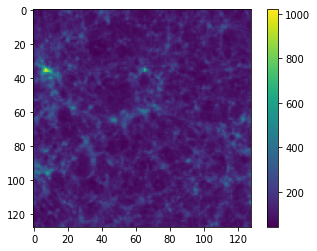

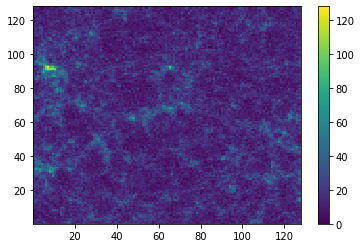

In [318]:
#samples_n = np.array(samples)
%pylab inline
imshow(np.flipud(np.sum(gal[0],axis=1).T))#,extent=[0,30,0,30])
plt.colorbar()
plt.show()

sample2d = plt.hist2d(samples_n[:,0],samples_n[:,2],bins=nc)
samples2d = sample2d[0]
samples2d *= factor
colorbar()

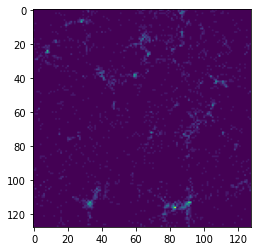

In [319]:
#pretty picture of samples
from scipy import ndimage
sample3d, _ = np.histogramdd(samples_n[:],bins=nc)
imshow(sample3d[10])

In [320]:
np.save("sample3d_temp",samples_n)

In [321]:
#photo-z errors
z_shift = np.random.randn(int(nc**3/factor)).reshape(1,-1,1).astype(np.float32)*2.0

In [322]:

samples_alter = np.load("./sample3d_temp.npy")
print(samples_alter.shape,z_shift.shape)
samples_alter[:,2] = np.mod(z_shift[0,:,0]+samples_alter[:,2],128)


sample3d2, _ = np.histogramdd(samples_alter,bins=nc)


(262144, 3) (1, 262144, 1)


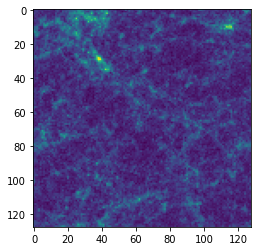

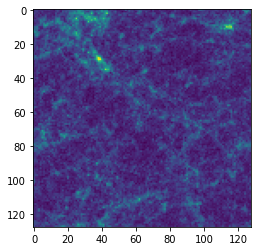

In [323]:
imshow(sample3d2[:,:,:].sum(axis=2))
show()
imshow(sample3d[:,:,:].sum(axis=2))

In [324]:
ndimage.gaussian_filter1d?

In [325]:
z_pdf = ndimage.gaussian_filter1d(sample3d,2,axis=2,mode="wrap").reshape(-1,128,128,128)

In [326]:
from tensorflow.contrib.opt import ScipyOptimizerInterface
from keras import optimizers
import keras.backend as K
import flowpm


maxiter = 30
gtol=1e-5/512
sigma=1.0
tf.reset_default_graph()

def pm(lin,b):
  state = flowpm.lpt_init(lin, a0=0.1)
  final_state = flowpm.nbody(state, stages, nc)
  final_field = flowpm.cic_paint(tf.zeros_like(lin), final_state[0])  
  #bias model to allow joint fit with bias parameteters... not very stable right now :P
  return b[0]*final_field + b[1]**2.0*final_field**2.0

def likelihood_poisson(inputs,data):
    inputs_clip = K.clip(inputs,0.001,1000)
    lamb = inputs_clip#/tf.reduce_sum(data) 
    x = data
    return tf.math.igammac(x**2.0 + 0.000001,lamb)#/tf.math.igammac(x,0)


def likelihood_fn(inputs, data):
  """ Evaluates the data chi-squared function through Fast PM
  """
  #Clipping very high values which end up dominating the likelihood
  data_clip = data#peak_smoother(data)
#K.clip(data,-25,10)
  inputs_clip = tf.exp(K.clip(inputs,-10,10))

  #weighted by number count in bin for poisson errors
  values = -tf.multiply(tf.multiply(inputs_clip,data),data)

  return values

xx = tf.placeholder(tf.float32, [1, nc, nc, nc]) #Starting Point of initial field
data = tf.placeholder(tf.float32, [1,nc, nc, nc]) #galaxy locations (x,y)

bias = tf.Variable([1.0,0.0], name="variables", trainable=False) #Bias, could be trained simultaniously

#zz = tf.Variable(samples_n[:,2].reshape(1,-1,1).astype(np.float32)+z_shift, name="variables", trainable=True) #redshift positions

linearkk = tf.get_variable('linmesh', shape=(1, nc, nc, nc),
            initializer=tf.random_normal_initializer(mean=1.0, stddev=0.5), trainable=True) #inital field

initlin_op = linearkk.assign(xx, name='initlin_op') #idk what this really does, some TF magic...


linear_wc = tfpm.r2c3d(linearkk, norm=nc**3, name=None)
linear_k = tf.multiply(linear_wc, (pkmesh/bs**3)**0.5)
linear = tfpm.c2r3d(linear_k, norm=nc**3, name=None)
        
evolved_field = pm(linear,bias) #evolve field


#print(yy.shape,zz.shape)
#galaxy_positions = tf.concat([yy,zz],axis=2) #full 3d positions




#data = flowpm.cic_paint(tf.zeros_like(linear), galaxy_positions) #paint field

#smooth reconstructed field by parameter which decays (helps redshift finding)
Rs = tf.placeholder(tf.float64, name='smoothing')
Rsm = tf.multiply(Rs, bs/nc)
Rsmsq = tf.multiply(Rsm, Rsm)
smwts = tf.exp(tf.multiply(-kmesh**2, Rsmsq))
print(data.shape)

data = data
#datak = tfpm.r2c3d(data, norm=nc**3)
#datak = tf.multiply(datak, tf.cast(smwts, tf.complex64))
#data = tfpm.c2r3d(datak, norm=nc**3)

print("ii", data.shape,evolved_field.shape)
#data = tf.Variable(tf.float32, shape=(nc,nc,nc),name="data")

#data = gaussian_blur(data)


likelihood = likelihood_poisson(evolved_field,data)

## smoooth
print("likehood:",likelihood.shape)

#projected field likelihood, strictly redundant with other field, but seems to help?
#likelihood_proj = likelihood_project(evolved_field,data)/nc

likelihood_f = tf.reduce_sum(likelihood)# + tf.reduce_sum(likelihood_proj)

#redshift prior

#zz_error = tf.reduce_sum((zz-(samples_n[:,2].reshape(1,-1,1)+z_shift))**2)

# Compute the 'gaussian' prior on field

lineark = flowpm.utils.r2c3d(linear, norm=nc**3)
priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
prior_1 = tf.reduce_mean(tf.multiply(priormesh, 1./pkmesh**2))*nc**3

# Compute the powerspectra

pk_it = pk(tf.squeeze(linear,0),shape = linear.shape[1:], boxsize= np.array([128,128,128]),kmin=0.001,dk=.05)

#Prior on PS w/ CV-like weighting
#CURRENTLY COMPARING AGAINST TRUE PS! Should make it compare to theory PS (small change...)
prior_3 = 0.1*tf.multiply((pk_it[1]-pk_fid[1])**2.0,900.0*pk_fid[0]**3/pk_fid[1]) 

prior_total = prior_1+ prior_3

logposterior = (tf.reduce_sum(likelihood_f) + tf.reduce_sum(prior_total)*(10-tf.cast(Rs,tf.float32)))

opt = ScipyOptimizerInterface(logposterior, var_list=[linearkk], method='L-BFGS-B',
                                            options={'maxiter': maxiter, 'gtol':gtol,'disp': True})


(1, 128, 128, 128)
ii (1, 128, 128, 128) (1, 128, 128, 128)
likehood: (1, 128, 128, 128)
(128, 128, 128)
2097152 96 2097152


/home/ben.horowitz/flowpm/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


In [327]:
z_pdf.shape

(1, 128, 128, 128)

In [328]:
#define starting point
starting_point = np.random.randn(1,nc,nc,nc)*1.01

sess = tf.Session()
sess.run(tf.global_variables_initializer())

batchsize = 1

# Initialize gradient descent at random point
sess.run(initlin_op, {xx:starting_point, data:z_pdf,Rs:0.0});
#sess.run(initzz_op, {zz_in: samples_n[:,2].reshape(1,int(32**3/factor),1)-0.45})

start_time = time.time()
for r0 in [5,3,2,1,0.0]: #note, don't have r0 > 10 since it will screw things up... see likelihood term
    print(r0)
    z = opt.minimize(sess, {data:z_pdf,Rs:r0})
    print("Run Time: ",time.time()-start_time)
    

5
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 461464.812500
  Number of iterations: 30
  Number of functions evaluations: 36
Run Time:  128.47271609306335
3
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 628196.812500
  Number of iterations: 30
  Number of functions evaluations: 34
Run Time:  233.58301210403442
2
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 708097.687500
  Number of iterations: 30
  Number of functions evaluations: 34
Run Time:  339.1424424648285
1
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 786823.625000
  Number of iterations: 30
  Number of functions evaluations: 34
Run Time:  444.63011860847473
0.0
INFO:tensorflow:Optimizat

In [331]:

test, bias_fit, fins, pk_it_out,cic_f = sess.run([linear, bias, evolved_field,pk_it,data], 
{xx:starting_point, data:z_pdf,Rs:0.0})#,zz:samples_n[:,2].reshape(1,int(32**3/factor),1)-0.45})


0
(262144, 3) (1, 262144, 1)


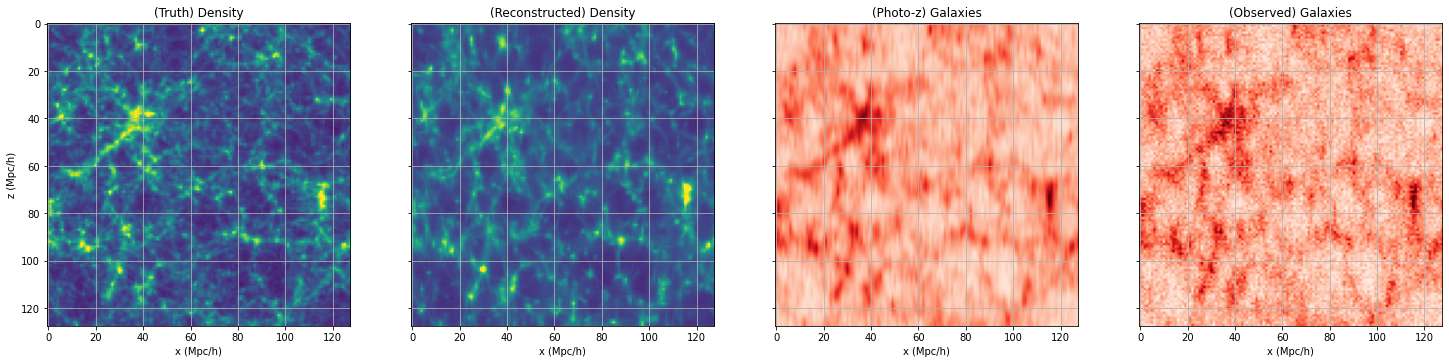

1
(262144, 3) (1, 262144, 1)


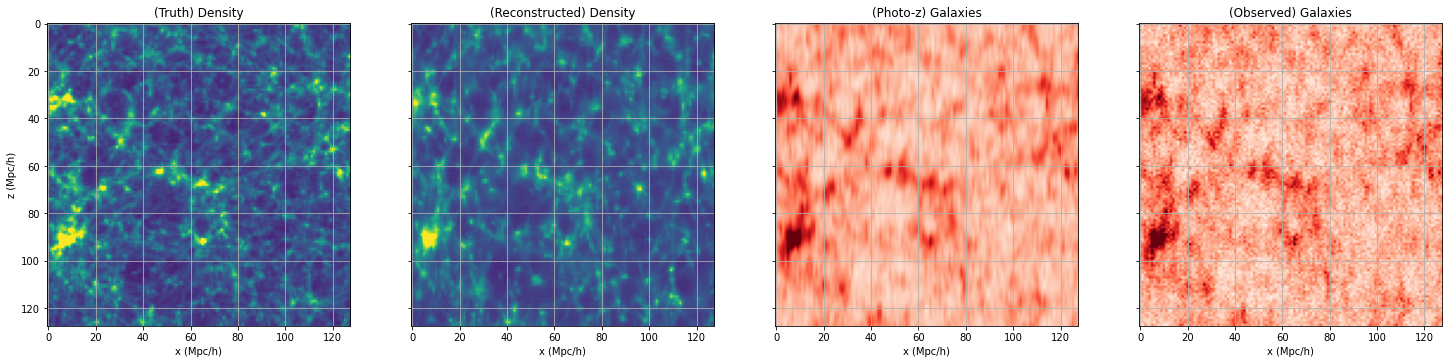

2
(262144, 3) (1, 262144, 1)


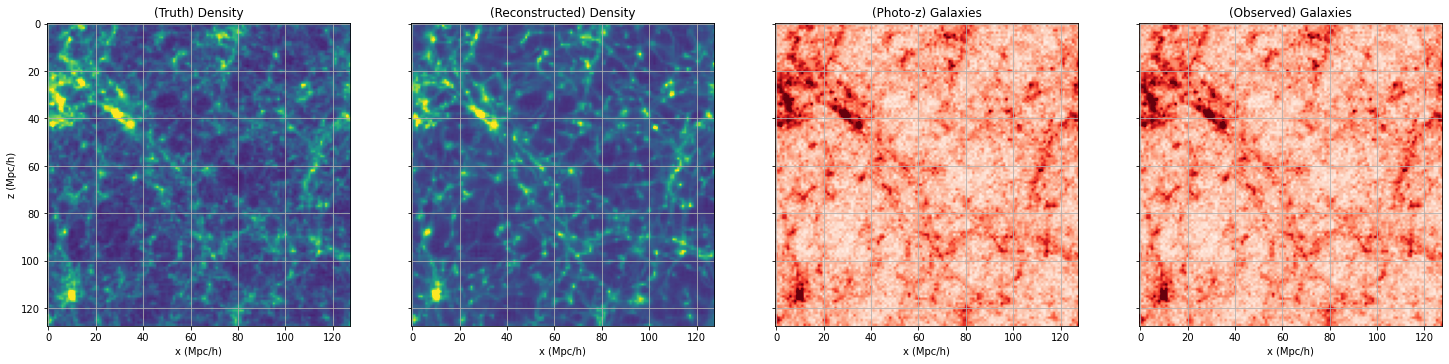

In [332]:

ax = 1

sm = 0
for ax in [0,1,2]:
    print(ax)
    _,axi = plt.subplots(1,4,sharey=True,figsize=(25,10))

    axi[0].set_title("(Truth) Density")

    axi[0].set_ylabel("z (Mpc/h)")
    axi[0].set_xlabel("x (Mpc/h)")

    axi[0].imshow(np.sum(ndimage.gaussian_filter(gal[0],sm),axis=ax).T,vmin=10,vmax=100*2*2)
    axi[0].grid()

    #colorbar()
    #show()

    axi[1].set_title("(Reconstructed) Density")
    axi[1].set_xlabel("x (Mpc/h)")

    axi[1].imshow(np.sum(ndimage.gaussian_filter(fins[0,:],sm),axis=ax).T,vmin=10,vmax=100*2*2)
    axi[1].grid()

    #colorbar()
    #plt.show()

    axi[2].set_title("(Photo-z) Galaxies")
    axi[2].set_xlabel("x (Mpc/h)")

    axi[2].imshow(np.sum(ndimage.gaussian_filter(cic_f[0],sm),axis=ax).T,vmin=0,vmax=100/factor*4,cmap="Reds")
    axi[2].grid()

    axi[3].set_title("(Observed) Galaxies")
    axi[3].set_xlabel("x (Mpc/h)")

    samples_alter = np.load("./sample3d_temp.npy")
    print(samples_alter.shape,z_shift.shape)
    samples_alter[:,2] = np.mod(z_shift[0,:,0]+samples_alter[:,2],128)

    sample3d2, _ = np.histogramdd(samples_alter,bins=nc)

    axi[3].imshow(np.sum(ndimage.gaussian_filter(sample3d2,sm),axis=ax).T,vmin=0,vmax=100/factor*4,cmap="Reds")
    axi[3].grid()

    show()


0
(262144, 3) (1, 262144, 1)


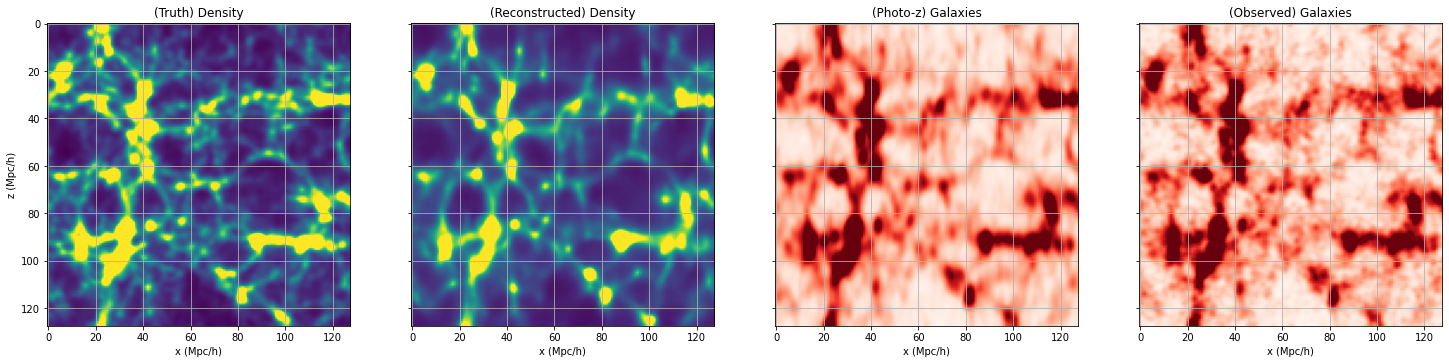

In [333]:

ax = 1

sm = 1
w = 10
for ax in [0]:
    print(ax)
    _,axi = plt.subplots(1,4,sharey=True,figsize=(25,10))

    axi[0].set_title("(Truth) Density")

    axi[0].set_ylabel("z (Mpc/h)")
    axi[0].set_xlabel("x (Mpc/h)")

    axi[0].imshow(np.sum(ndimage.gaussian_filter(gal[0],sm)[:w,:,:],axis=ax).T,vmin=10/12,vmax=100*2*2/12)
    axi[0].grid()

    #colorbar()
    #show()


    axi[1].set_title("(Reconstructed) Density")
    axi[1].set_xlabel("x (Mpc/h)")

    axi[1].imshow(np.sum(ndimage.gaussian_filter(fins[0,:],sm)[:w,:,:],axis=ax).T,vmin=10/12,vmax=100*2*2/12)
    axi[1].grid()

    #colorbar()
    #plt.show()



    axi[2].set_title("(Photo-z) Galaxies")
    axi[2].set_xlabel("x (Mpc/h)")

    axi[2].imshow(np.sum(ndimage.gaussian_filter(cic_f[0],sm)[:w,:,:],axis=ax).T,vmin=0,vmax=100/factor*4/12,cmap="Reds")
    axi[2].grid()

    axi[3].set_title("(Observed) Galaxies")
    axi[3].set_xlabel("x (Mpc/h)")


    samples_alter = np.load("./sample3d_temp.npy")
    print(samples_alter.shape,z_shift.shape)
    samples_alter[:,2] = np.mod(z_shift[0,:,0]+samples_alter[:,2],128)


    sample3d2, _ = np.histogramdd(samples_alter,bins=nc)


    axi[3].imshow(np.sum(ndimage.gaussian_filter(sample3d2,sm)[:w,:,:],axis=ax).T,vmin=0,vmax=100/factor*4/12,cmap="Reds")
    axi[3].grid()

    show()


Text(0, 0.5, 'P(k)')

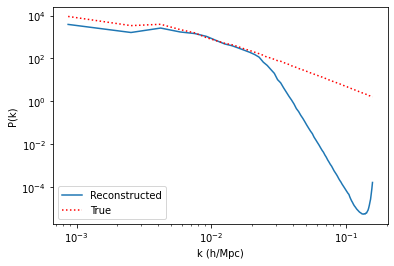

In [334]:
plt.loglog(pk_it_out[0]/30,pk_it_out[1],label="Reconstructed")
plt.loglog(pk_fid[0]/30,pk_fid[1],"r:",label="True")
plt.legend(loc=3)
plt.xlabel("k (h/Mpc)")
plt.ylabel("P(k)")


#### 

In [144]:
tf.math.igamma(x,lamb)/tf.math.igamma(x,0)

<function tensorflow.python.ops.gen_math_ops.igamma(a, x, name=None)>

In [154]:
import scipy
scipy.special.gammainc

<ufunc 'gammainc'>

In [162]:
scipy.special.gammainc(0,0.01)

1.0